In [267]:
from pathlib import Path
import sys
import zipfile
from typing import List
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
import pickle
from glob import glob
from typing import Tuple
import os

## ML preprocessing pipeline

In [196]:
def load_depth(fpath: str) -> Tuple[bytes, int, int, float, float]:
    with zipfile.ZipFile(fpath) as z:
        with z.open('data') as f:
            # Example for a first_line:
            # '180x135_0.001_7_0.57045287_-0.0057296_0.0022602521_0.82130724_-0.059177425_0.0024800065_0.030834956'
            first_line = f.readline().decode().strip()

            file_header = first_line.split("_")

            # header[0] example: 180x135
            width, height = file_header[0].split("x")
            width, height = int(width), int(height)
            depth_scale = float(file_header[1])
            max_confidence = float(file_header[2])

            depth_data = f.read()
    return depth_data, width, height, depth_scale, max_confidence

In [259]:
IDENTITY_MATRIX_4D = [1., 0., 0., 0.,
                      0., 1., 0., 0.,
                      0., 0., 1., 0.,
                      0., 0., 0., 1.]

In [260]:
def matrix_calculate(position: List[float], rotation: List[float]) -> List[float]:
    """Calculate a matrix image->world from device position and rotation"""

    output = IDENTITY_MATRIX_4D

    sqw = rotation[3] * rotation[3]
    sqx = rotation[0] * rotation[0]
    sqy = rotation[1] * rotation[1]
    sqz = rotation[2] * rotation[2]

    invs = 1 / (sqx + sqy + sqz + sqw)
    output[0] = (sqx - sqy - sqz + sqw) * invs
    output[5] = (-sqx + sqy - sqz + sqw) * invs
    output[10] = (-sqx - sqy + sqz + sqw) * invs

    tmp1 = rotation[0] * rotation[1]
    tmp2 = rotation[2] * rotation[3]
    output[1] = 2.0 * (tmp1 + tmp2) * invs
    output[4] = 2.0 * (tmp1 - tmp2) * invs

    tmp1 = rotation[0] * rotation[2]
    tmp2 = rotation[1] * rotation[3]
    output[2] = 2.0 * (tmp1 - tmp2) * invs
    output[8] = 2.0 * (tmp1 + tmp2) * invs

    tmp1 = rotation[1] * rotation[2]
    tmp2 = rotation[0] * rotation[3]
    output[6] = 2.0 * (tmp1 + tmp2) * invs
    output[9] = 2.0 * (tmp1 - tmp2) * invs

    output[12] = -position[0]
    output[13] = -position[1]
    output[14] = -position[2]
    return output

In [261]:
def read_depthmap_data(path):
#         path = extract_depthmap(depthmap_fpath)
        with open(path, 'rb') as f:
            header_line = f.readline().decode().strip()
            header_parts = header_line.split('_')
            res = header_parts[0].split('x')
            width = int(res[0])
            height = int(res[1])
            depth_scale = float(header_parts[1])
            max_confidence = float(header_parts[2])
            if len(header_parts) >= 10:
                position = (float(header_parts[7]), float(header_parts[8]), float(header_parts[9]))
                rotation = (float(header_parts[3]), float(header_parts[4]),
                            float(header_parts[5]), float(header_parts[6]))
                device_pose = matrix_calculate(position, rotation)
            else:
                device_pose = IDENTITY_MATRIX_4D
            data = f.read()
            f.close()
        return width, height, data, depth_scale, max_confidence, device_pose, header_line

In [263]:
def parse_depth(tx: int, ty: int, data: bytes, depth_scale: float, width: int) -> float:
    assert isinstance(tx, int)
    assert isinstance(ty, int)

    depth = data[(ty * width + tx) * 3 + 0] << 8
    depth += data[(ty * width + tx) * 3 + 1]

    depth *= depth_scale
    return depth

In [264]:
def prepare_depthmap(data: bytes, width: int, height: int, depth_scale: float) -> np.array:
    """Convert bytes array into np.array"""
    output = np.zeros((width, height, 1))
    for cx in range(width):
        for cy in range(height):
            # depth data scaled to be visible
            output[cx][height - cy - 1] = parse_depth(cx, cy, data, depth_scale, width)
    arr = np.array(output, dtype='float32')
    return arr.reshape(width, height)

In [266]:
def preprocess_depthmap(depthmap):
    # TODO here be more code.
    return depthmap.astype("float32")

In [147]:
normalisation_value = 7.5
image_target_width = 180
image_target_height = 240
# depthmap = tf.image.resize(depthmap, (image_target_height, image_target_width))

In [107]:
output = 'output'
os.mkdir(output)

In [200]:
artifacts_raw = glob('scans/f43d1b80-7859-11eb-86ba-93cb6c3c5609/depth/*')
print(artifacts_raw)
target_path ='output'
for artifacts in artifacts_raw:
    depth_data, width, height, depth_scale, max_confidence =load_depth(artifacts)
    depthmap = prepare_depthmap(depth_data,width,height,depth_scale)
    depthmap = np.expand_dims(depthmap, axis=2)
    depthmap = preprocess_depthmap(depthmap)
    depthmap = depthmap/normalisation_value
    artifact_name = artifacts.split('/')[-1]
    complete_path = f'{target_path}/{artifact_name}.p'
    pickle.dump(depthmap, open(complete_path, "wb"))  

['scans/f43d1b80-7859-11eb-86ba-93cb6c3c5609/depth/f399d6a0-7859-11eb-86ba-c3dc5ee5a617', 'scans/f43d1b80-7859-11eb-86ba-93cb6c3c5609/depth/f3aa9f80-7859-11eb-86ba-537bfe54aa70', 'scans/f43d1b80-7859-11eb-86ba-93cb6c3c5609/depth/f3bcef00-7859-11eb-86ba-932c12127d6c', 'scans/f43d1b80-7859-11eb-86ba-93cb6c3c5609/depth/f3d0c520-7859-11eb-86ba-bbc8d9e15e48', 'scans/f43d1b80-7859-11eb-86ba-93cb6c3c5609/depth/f3e314a0-7859-11eb-86ba-9390e15d72d1', 'scans/f43d1b80-7859-11eb-86ba-93cb6c3c5609/depth/f3f6eac0-7859-11eb-86ba-1b2b943a9013', 'scans/f43d1b80-7859-11eb-86ba-93cb6c3c5609/depth/f4093a40-7859-11eb-86ba-cf61a7783fb9', 'scans/f43d1b80-7859-11eb-86ba-93cb6c3c5609/depth/f41d1060-7859-11eb-86ba-bba048f2e2c3', 'scans/f43d1b80-7859-11eb-86ba-93cb6c3c5609/depth/f42dd940-7859-11eb-86ba-5bcdd904a2a7']


(240, 180, 1)


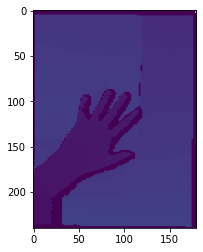

In [201]:
ml_depthmap = pickle.load(open('output/f41d1060-7859-11eb-86ba-bba048f2e2c3.p', "rb"))
print(ml_depthmap.shape)
plt.imshow(np.squeeze(ml_depthmap))

In [115]:
rg_depthmaps = 'rg-output'
ml_depthmaps ='output'

In [186]:
depth_path = 'scans/f43d1b80-7859-11eb-86ba-93cb6c3c5609/depth/f41d1060-7859-11eb-86ba-bba048f2e2c3'
extract_depthmap(depth_path)
depthmap_path= 'data/data'
width, height, data, depth_scale, max_confidence, device_pose, header_line =  read_depthmap_data(depthmap_path)
depthmap = prepare_depthmap(data,width,height,depth_scale)
normalisation_value = 7.5
# image_target_width = 180
# image_target_height = 240
# depthmap = np.expand_dims(depthmap, axis=2)
# depthmap = preprocess_depthmap(depthmap)
# depthmap = depthmap/normalisation_value
depthmap.shape

(240, 180)

## Processing multiple scans on cgm-ml and saving them in pickle

In [241]:
target = 'ml-scans'
scan_folders = glob.glob('scan_with_depthmap_hwawei/*' + os.path.sep)
os.mkdir(target)

In [245]:
for scans in scan_folders:
    files = f'{scans}depth/*'
    folder = scans.split('/')[1]
    full_path = f'{target}/{folder}'
    os.mkdir(full_path)
    scans_depthmaps = glob(files)
    for artifacts in scans_depthmaps:
        depth_data, width, height, depth_scale, max_confidence =load_depth(artifacts)
        depthmap = prepare_depthmap(depth_data,width,height,depth_scale)
        depthmap = np.expand_dims(depthmap, axis=2)
        depthmap = preprocess_depthmap(depthmap)
        depthmap = depthmap/normalisation_value
        artifact_name = artifacts.split('/')[-1]
        complete_path = f'{full_path}/{artifact_name}.p'
        pickle.dump(depthmap, open(complete_path, "wb"))  

## Gathering all the pickles files for cgm-rg and cgm-ml

In [254]:
rg_artifacts = glob('rg-scans/**/*.p')
ml_artifacts = glob('ml-scans/**/*.p')

## compare scans of cgm-ml and cgm-rg

In [258]:
ml_output = 'ml-scans/'
for data in rg_artifacts:
    artifacts = data.split('/')[-1]
    scans = data.split('/')[1]
    rg_depthmap = pickle.load(open(data, "rb"))
    ml_data = f'{ml_output}{scans}/{artifacts}'
    ml_depthmap = pickle.load(open(ml_data, "rb"))
    result = (rg_depthmap == ml_depthmap).all()
    if result is False:
        print(data)